# 3rd Year Project - Alfred Backhouse
## Training creative cellular automata using GANs. 

on server: 
ssh alfred@conway.cs.ox.ac.uk
jupyter notebook --no-browser --port 8080
on local: ssh -NL 8080:localhost:8080 alfred@conway.cs.ox.ac.uk

# Set some initial parameters 

In [1]:
ITER_N = 120
CHANNEL_N = 16 # Number of CA state channels
CELL_FIRE_RATE = 0.5
SEED_STD = 0.1
batch_size = 64

# Imports and image / video utities 

In [2]:
import numpy as np
import matplotlib.pylab as pl

import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import backend
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import Constraint
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from datetime import datetime
# Get the current date in YYYYMMDD format
current_date = datetime.now().strftime("%Y%m%d")

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Load training data

In [4]:
# Load MNIST data
(original_train_images, original_train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the entire dataset before splitting
normalized_images = original_train_images.reshape(original_train_images.shape[0], -1).astype('float32') / 255

# Define a split ratio for the dataset
split_ratio = 0.8  # e.g., 80% for training, 20% for validation / testing

# Calculate the number of images to include in the training set
num_train_images = int(len(normalized_images) * split_ratio)

# Split the images and labels into training and test sets
train_images = normalized_images[:num_train_images]
train_labels = original_train_labels[:num_train_images]
val_images = normalized_images[num_train_images:]
val_labels = original_train_labels[num_train_images:]

# Create a TensorFlow dataset for each digit in the training set
datasets = []
for digit in range(10):
    idx = train_labels == digit
    digit_images = train_images[idx]
    datasets.append(tf.data.Dataset.from_tensor_slices(digit_images).shuffle(1000).batch(60))

In [5]:
# Check gpu
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# Build the CA / generator model (with some utitilies for this)

In [6]:
#@title CA model and utils
def to_greyscale(x):
    y = tf.clip_by_value(x[..., 0:1], 0.0, 1.0)
    return y

def get_living_mask(x):
    alpha = x[:, :, :, 0:1]
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def make_seed(num_examples, channel_n=CHANNEL_N, seed_std=SEED_STD):
    h, w = 28,28
    seed = np.zeros([num_examples, h, w, channel_n], np.float32)
    for i in range(h//2 - 1, h//2 + 1):
        for j in range(w//2-1, w//2 + 1):
            seed[:, i, j, 0] = np.random.uniform(1, 1, size = num_examples)
            seed[:, i, j, 1:] = np.random.normal(0, seed_std, size = seed[:, i, j, 1:].shape)
    return seed

# Gaussian initialization
class CustomInitializer(Initializer):
    def __init__(self, mean=0.0, stddev=0.01):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, shape, dtype=np.float32):
        return tf.random.normal(shape, mean=self.mean, stddev=self.stddev, dtype=dtype)

class build_generator(tf.keras.Model):

    def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate

        self.perceive = tf.keras.Sequential([
            Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"), # 80 filters, 3x3 kernel
        ])

        self.dmodel = tf.keras.Sequential([
            Conv2D(80, 1, activation=tf.nn.relu),
            Conv2D(self.channel_n, 1, activation=tf.nn.tanh,
                kernel_initializer=tf.zeros_initializer),
        ])

        self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

    @tf.function
    def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
        pre_life_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y)*step_size
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask

        return x * tf.cast(life_mask, tf.float32)

build_generator().dmodel.summary()

# TODO: TRY SIGMOID, square root loss 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (1, 3, 3, 80)             6480      
                                                                 
 conv2d_2 (Conv2D)           (1, 3, 3, 16)             1296      
                                                                 
Total params: 7776 (30.38 KB)
Trainable params: 7776 (30.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# The kernel functions

In [7]:
def compute_kernel(x, y, sigma_list):
    """Computes a Gaussian kernel between two sets of samples using multiple bandwidth parameters."""
    beta_list = [1.0 / (2.0 * sigma**2) for sigma in sigma_list]
    x_expanded = tf.expand_dims(x, 1)
    y_expanded = tf.expand_dims(y, 0)
    kernel_val = 0.
    for beta in beta_list:
        beta = tf.cast(beta, tf.float32)
        squared_diff = tf.reduce_sum(tf.square(x_expanded - y_expanded), 2)
        kernel_val += tf.exp(-beta * squared_diff)
    return kernel_val / tf.cast(tf.size(sigma_list), tf.float32)

def compute_mmd(x, y, sigma_list=[2, 5, 10, 20, 40, 80]):
    """Computes the Maximum Mean Discrepancy (MMD) between two sets of samples, x and y."""
    x_kernel = compute_kernel(x, x, sigma_list)
    y_kernel = compute_kernel(y, y, sigma_list)
    xy_kernel = compute_kernel(x, y, sigma_list)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)


In [8]:
def log_mean_exp(a):
    """Compute the log of the mean of exponentials of input elements."""
    max_ = tf.reduce_max(a, axis=1, keepdims=True)
    return max_ + tf.math.log(tf.reduce_mean(tf.exp(a - max_), axis=1))

def tensorflow_parzen_estimator(mu, sigma):
    """Constructs a Parzen window estimator using TensorFlow."""
    mu = tf.convert_to_tensor(mu, dtype=tf.float32)
    sigma = tf.constant(sigma, dtype=tf.float32)
    
    def parzen_estimator(x):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        a = (tf.expand_dims(x, 1) - tf.expand_dims(mu, 0)) / sigma
        E = log_mean_exp(-0.5 * tf.reduce_sum(tf.square(a), axis=2))
        Z = mu.shape[1] * tf.math.log(sigma * tf.sqrt(2 * np.pi))
        return E - Z
    
    return parzen_estimator

def compute_log_likelihood(parzen, data, batch_size=100):
    """Computes log-likelihood of data given a Parzen window estimator."""
    n_batches = int(np.ceil(data.shape[0] / batch_size))
    log_likelihoods = []
    for i in range(n_batches):
        batch = data[i*batch_size:(i+1)*batch_size]
        log_likelihood = parzen(batch)
        log_likelihoods.append(log_likelihood)
    return tf.reduce_mean(log_likelihoods)

def find_best_sigma(samples, data, sigma_range, batch_size=100, verbose=True):
    """Finds the best sigma value over a range by optimizing log-likelihood."""
    best_log_likelihood = float('-inf')
    best_sigma = 0
    
    for sigma in sigma_range:
        parzen = tensorflow_parzen_estimator(samples, sigma)
        log_likelihood = compute_log_likelihood(parzen, data, batch_size)
        
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_sigma = sigma
            
        if verbose:
            print(f'sigma={sigma}, log_likelihood={log_likelihood.numpy():.2f}')
    
    if verbose:
        print('====================')
        print(f'Best log_likelihood={best_log_likelihood.numpy():.2f} for sigma={best_sigma}')
        print('')
    
    return best_log_likelihood, best_sigma

In [ ]:
def generate_images(model, channel_n=CHANNEL_N, seed_std=SEED_STD, iter_n=ITER_N):
    x = make_seed(16, channel_n=channel_n, seed_std=seed_std)
    for i in range(iter_n):
        x = model(x, training=False) 
    generated_images = x
    fig, axes = plt.subplots(1, 16, figsize=(20, 2))
    greyscale_images = to_greyscale(generated_images)
    for i, ax in enumerate(axes):
        ax.imshow(greyscale_images[i, :, :, 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(f'Generated Images for Digit {target_digit}')
    return fig, axes

In [9]:
def plot_training_metrics(epochs, mmd_losses, parzen_log_likelihoods, parzen_eval_interval, target_digit, params):
    """
    Plots and saves the training metrics including MMD Loss and Parzen Window Log Likelihood
    for a specific target digit.
    
    Parameters:
    - epochs: Total number of epochs trained.
    - mmd_losses: List of MMD losses recorded after each epoch.
    - parzen_log_likelihoods: List of Parzen window log likelihoods recorded at specified intervals.
    - parzen_eval_interval: Interval at which Parzen window log likelihoods were evaluated.
    - target_digit: The target digit for which the model was trained.
    """
    
    # Create directory if it doesn't exist
    save_dir = f'evaluation/{current_date}/{target_digit}'
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, "train_metrics"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "generated_images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "model"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "log_likelihoods"), exist_ok=True)
    
    plt.figure(figsize=(12, 6))
    
    # Plotting MMD Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), mmd_losses, label='MMD Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MMD Loss')
    plt.title('MMD Loss over Epochs')
    plt.legend()
    
    # Plotting Parzen Window Log Likelihood
    plt.subplot(1, 2, 2)
    epochs_evaluated = list(range(parzen_eval_interval, epochs + 1, parzen_eval_interval))
    plt.plot(epochs_evaluated, parzen_log_likelihoods, label='Parzen Log Likelihood', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Log Likelihood')
    plt.title('Parzen Window Log Likelihood over Epochs')
    plt.legend()
    
    plt.tight_layout()
    
    # Save the figure
    filename = os.path.join(save_dir, f'train_metrics/train_metrics_{params["fire_rate"]}_{params["channel_n"]}_{params["lr"]}_{params["epochs"]}_{params["iter_n"]}_{params["seed_std"]}_.png')
    plt.savefig(filename)
    plt.close()  # Close the figure to free memory
    
    # Save the generated images
    (fig, axes) = generate_images(params["model"], params["model"].channel_n, params["seed_std"], params["iter_n"])
    fig.savefig(filename.replace('train_metrics/train_metrics', 'generated_images/generated_images'))
    plt.close()

    # Save the model
    model_filename = filename.replace("train_metrics/train_metrics", "model/model")
    params["model"].save_weights(model_filename)
    

In [12]:
def train_model_for_digit(target_digit, params, sigma_range=np.arange(0.1, 0.5, 0.05), parzen_eval_interval=1):
    model = params["model"]
    optimizer = params["optimizer"]
    epochs = params["epochs"]
    seed_std = params["seed_std"]
    channel_n = model.channel_n
    iter_n = params["iter_n"]
    
    log_likelihood = -10000.0

    digit_dataset = datasets[target_digit]
    
    idx = val_labels == target_digit
    digits = val_images[idx]
    test_data = digits[:len(digits) // 100]

    mmd_losses = []
    parzen_log_likelihoods = []

    for epoch in range(epochs):
        epoch_mmd_losses = []
        for real_images in digit_dataset:
            x = make_seed(batch_size, channel_n=channel_n, seed_std=seed_std)
            
            with tf.GradientTape() as tape:
                for i in tf.range(iter_n):
                    x = model(x, training=True)
                generated_images = tf.reshape(x[..., 0], [batch_size, 28*28])
                mmd_loss = compute_mmd(real_images, generated_images)

            grads = tape.gradient(mmd_loss, model.weights)
            grads = [g/(tf.norm(g)+1e-8) for g in grads]
            optimizer.apply_gradients(zip(grads, model.weights))
            epoch_mmd_losses.append(mmd_loss.numpy())
        
        epoch_mmd_loss_avg = np.mean(epoch_mmd_losses)
        mmd_losses.append(epoch_mmd_loss_avg)
        
        # Evaluate using Parzen window estimator periodically
        if (epoch+1) % parzen_eval_interval == 0:
            x = make_seed(test_data.shape[0], channel_n=channel_n, seed_std=seed_std)
            for i in range(iter_n): 
                x = model(x, training=False)
            samples = tf.reshape(x[..., 0], [x.shape[0], 28*28])
            log_likelihood, best_sigma = find_best_sigma(samples, test_data, sigma_range, verbose=False)
            parzen_log_likelihoods.append(log_likelihood.numpy())
#             print(f'Epoch {epoch+1}, Parzen Log Likelihood: {log_likelihood.numpy()}')
#             print(f'Epoch {epoch+1}, MMD Loss: {epoch_mmd_loss_avg}')
    
        
    generate_images(model, channel_n=channel_n, seed_std=seed_std, iter_n=iter_n)
    plot_training_metrics(epochs, mmd_losses, parzen_log_likelihoods, parzen_eval_interval, target_digit, params)
    
    assert log_likelihood != -10000
    return log_likelihood

Testing models
Currently on model = <__main__.build_generator object at 0x2cb931a50>


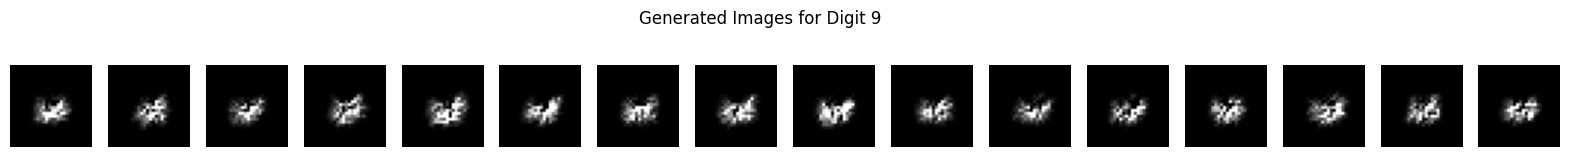

ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

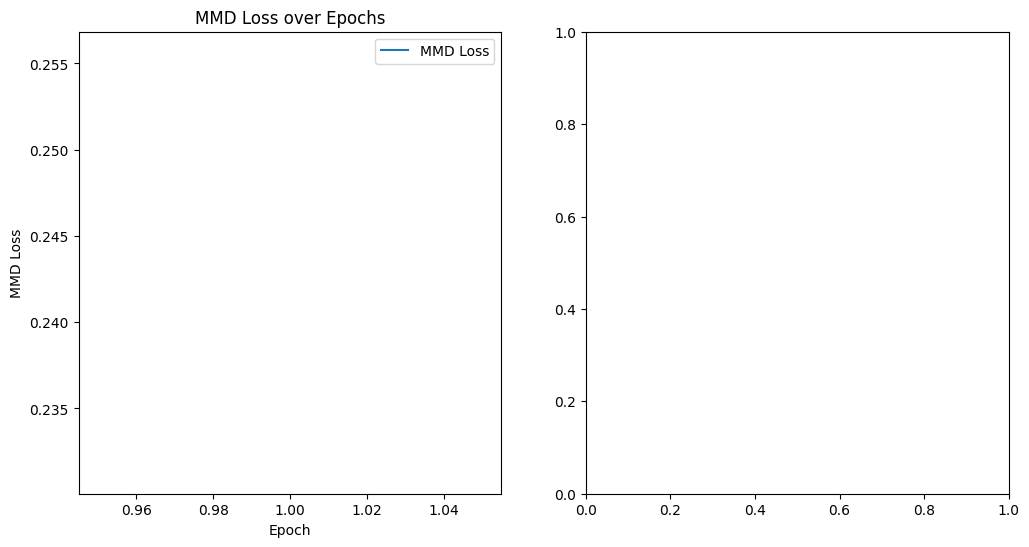

In [18]:
target_digit = 4

params = {
    "fire_rate": [0.2, 0.5, 0.8, 1.0],
    "channel_n": [4, 8, 16],
    "lr": [1e-5, 3e-5, 1e-4, 3e-4, 1e-3],
    "epochs": [50],
    "iter_n": [70, 100, 130, 160],
    "seed_std": [0.01, 0.1, 1.0, 10.0],
}

best_params = {
    "fire_rate": 0.5,
    "channel_n": CHANNEL_N,
    "model": build_generator(),
    "lr": 2e-4,
    "optimizer": tf.keras.optimizers.Adam(learning_rate=2e-4),
    "epochs": 2,
    "iter_n": 20,
    "seed_std": SEED_STD,
}

best_log_likelihood = float('-inf')

for param_name, param_values in params.items():
    print(f'Testing {param_name}s')
    current_params = best_params.copy()
    likelihoods = []
    param_saved_vals = []

    for param in param_values: 
        print(f"Currently on {param_name} = {param}")
        current_params[param_name] = param

        current_params["model"] = build_generator(fire_rate=current_params["fire_rate"], channel_n=current_params["channel_n"])
        current_params["optimizer"] = tf.keras.optimizers.Adam(learning_rate=current_params["lr"])

        likelihood = train_model_for_digit(target_digit, current_params)
        likelihoods.append(likelihood)
        param_saved_vals.append(param if not isinstance(param, tf.keras.optimizers.Optimizer) else param.learning_rate.numpy())  # Handling optimizer objects differently

        if likelihood > best_log_likelihood:
            best_log_likelihood = likelihood
            best_params[param_name] = param
            print(f"New best {param_name} = {param} with loss {likelihood}")
        else:
            print(f"Current {param_name} = {param} with loss {likelihood}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(param_saved_vals, likelihoods, marker='o', linestyle='-')
    plt.title(f'Log Likelihood vs. {param_name}')
    plt.xlabel(param_name if param_name != 'optimizers' else 'Learning Rate')
    plt.ylabel('Log Likelihood')
    plt.grid(True)
    

    # Save the plot
    # Create directory if it doesn't exist
    save_dir = f'evaluation/{current_date}/{target_digit}'
    os.makedirs(save_dir, exist_ok=True)

    filename = os.path.join(save_dir, f'log_likelihoods/log_likelihood_vs_{param_name}.png')
    plt.savefig(filename)
    plt.show()
    plt.close()  # Close the figure to free memory
    

# Display the creations

In [14]:
def print_image_sample(images): 
    plt.figure(figsize=(10, 10))
    images = to_greyscale(images)
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

In [15]:
def generate_and_save_images(model):
    
    x = make_seed(16)

    for i in tf.range(iter_n):
        x = model(x, training=False)
    print_image_sample(x)

In [16]:
generate_and_save_images(models[4])


ValueError: Exception encountered when calling layer 'build_generator_5' (type build_generator).

in user code:

    File "/var/folders/8f/dj6l0c6d1gz1wr69wgspd05c0000gn/T/ipykernel_47738/1852463185.py", line 51, in call  *
        y = self.perceive(x)
    File "/Users/alfredbackhouse/ML/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/Users/alfredbackhouse/ML/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_10' (type Sequential).
    
    Input 0 of layer "conv2d_15" is incompatible with the layer: expected axis -1 of input shape to have value 4, but received input with shape (16, 28, 28, 16)
    
    Call arguments received by layer 'sequential_10' (type Sequential):
      • inputs=tf.Tensor(shape=(16, 28, 28, 16), dtype=float32)
      • training=False
      • mask=None


Call arguments received by layer 'build_generator_5' (type build_generator):
  • x=tf.Tensor(shape=(16, 28, 28, 16), dtype=float32)
  • fire_rate=None
  • angle=0.0
  • step_size=1.0

## Evaluation

In [ ]:
# Use the function to find the best sigma
target_digit = 4
idx = train_labels == target_digit
digit_images = train_images[idx]
data = digit_images[:1000]

model = models[target_digit]
x = make_seed(data.shape[0])
for i in range(iter_n): 
    x = model(x, training=False)

In [ ]:
import tensorflow as tf
import numpy as np

def log_mean_exp(a):
    """Compute the log of the mean of exponentials of input elements."""
    max_ = tf.reduce_max(a, axis=1, keepdims=True)
    return max_ + tf.math.log(tf.reduce_mean(tf.exp(a - max_), axis=1))

def tensorflow_parzen_estimator(mu, sigma):
    """Constructs a Parzen window estimator using TensorFlow."""
    mu = tf.convert_to_tensor(mu, dtype=tf.float32)
    sigma = tf.constant(sigma, dtype=tf.float32)
    
    def parzen_estimator(x):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        a = (tf.expand_dims(x, 1) - tf.expand_dims(mu, 0)) / sigma
        E = log_mean_exp(-0.5 * tf.reduce_sum(tf.square(a), axis=2))
        Z = mu.shape[1] * tf.math.log(sigma * tf.sqrt(2 * np.pi))
        print(mu.shape[1])
        return E - Z
    
    return parzen_estimator

def compute_log_likelihood(parzen, data, batch_size=100):
    """Computes log-likelihood of data given a Parzen window estimator."""
    n_batches = int(np.ceil(data.shape[0] / batch_size))
    log_likelihoods = []
    for i in range(n_batches):
        batch = data[i*batch_size:(i+1)*batch_size]
        log_likelihood = parzen(batch)
        log_likelihoods.append(log_likelihood)
    return tf.reduce_mean(log_likelihoods)

def find_best_sigma(samples, data, sigma_range, batch_size=100, verbose=True):
    """Finds the best sigma value over a range by optimizing log-likelihood."""
    best_log_likelihood = float('-inf')
    best_sigma = 0
    
    for sigma in sigma_range:
        parzen = tensorflow_parzen_estimator(samples, sigma)
        log_likelihood = compute_log_likelihood(parzen, data, batch_size)
        
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_sigma = sigma
            
        if verbose:
            print(f'sigma={sigma}, log_likelihood={log_likelihood.numpy():.2f}')
    
    if verbose:
        print('====================')
        print(f'Best log_likelihood={best_log_likelihood.numpy():.2f} for sigma={best_sigma}')
        print('')
    
    return best_log_likelihood, best_sigma

# Example usage
# Assuming `samples` are your generated samples and `data` is the dataset you want to evaluate
sigma_range = np.arange(0.1, 0.5, 0.05)  # Adjust this as necessary

print(x.shape)
samples = tf.reshape(x[..., 0], [x.shape[0], 28*28])
print(samples.shape)
best_log_likelihood, best_sigma = find_best_sigma(samples, data, sigma_range)
print(f"Best Sigma: {best_sigma}, Log Likelihood: {best_log_likelihood.numpy()}")


(1000, 28, 28, 16)
(1000, 784)
784
784
784
784
784
784
784
784
784
784
sigma=0.1, log_likelihood=-3045.50
784
784
784
784
784
784
784
784
784
784
sigma=0.15000000000000002, log_likelihood=-1068.79
784
784
784
784
784
784
784
784
784
784
sigma=0.20000000000000004, log_likelihood=-491.22
784
784
784
784
784
784
784
784
784
784
sigma=0.25000000000000006, log_likelihood=-294.44
784
784
784
784
784
784
784
784
784
784
sigma=0.30000000000000004, log_likelihood=-235.45
784
784
784
784
784
784
784
784
784
784
sigma=0.3500000000000001, log_likelihood=-234.55
784
784
784
784
784
784
784
784
784
784
sigma=0.40000000000000013, log_likelihood=-260.22
784
784
784
784
784
784
784
784
784
784
sigma=0.45000000000000007, log_likelihood=-298.38
Best log_likelihood=-234.55 for sigma=0.3500000000000001

Best Sigma: 0.3500000000000001, Log Likelihood: -234.55296325683594


more parameters
LSTMs
Comparison between models - gradients, norm, ablation study, baseline, 
Start writeup, read papers, 

conda create -n nca1 python=3.11
conda activate nca1
conda install -c conda-forge matplotlib
pip install tensorflow[and-cuda]
conda install ipykernel
